# Tutorial 2.1: One-Body Potential Energy Surface

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [13]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.x.y Normal Modes Configuration Generation

Now, we will generate the first batch of configurations for our training set. This batch will come from randomly sampling the vibrational normal modes of methylamine.

First, we need to calculate the vibrational modes of the optimized geometry:

In [14]:
minimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)
vibrational_modes_CH3NH2 = read_vibrational_modes(vibrational_modes_CH3NH2_path)

In [15]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        classical=False,
)
configurations_vibrational_modes_CH3NH2 = list(configuration_generator.generate_configurations(num_configs=1000, seed=54321))
write_systems(pip_1b_modes_configs_path, configurations_vibrational_modes_CH3NH2)

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.0001860524825039312 | x < 0.45 : 0.0009302624125196561 | x < 0.75 : 0.0018605248250393122 | x < 0.95 : 0.0037210496500786243 | otherwise : 0.00930262412519656 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 1000 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 1000 configs.


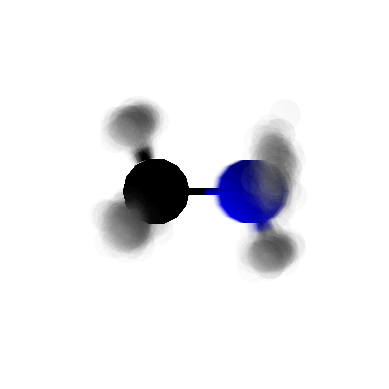

In [16]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.02,
    num_to_show=100
)

Note: the seed here determines which configurations get generated. The same seed will always produce the same configurations. In a later step, we "cheat" and have pre-performed the CCSD(T) calculations for these structures, so please don't change the seed, because then the energies we give you wont match the structures that get generated!

## II.1.? Parallel-Bias Metadynamics Configuration Generation

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

In [8]:
bond_params, angle_params, dihedral_params, nonbonded_params = get_pbmetad_parameters(
        minimized_structure_CH3NH2,
        ...
)

Ellipsis

In [ ]:
bond_params

In [ ]:
angle_params

In [ ]:
dihedral_params

In [73]:
nonbonded_params

In [ ]:
perform_pbmetad_simulation(
        [minimized_structure_CH3NH2],
        out_path=...,
        bond_params=bond_params,
        angle_params=angle_params,
        dihedral_params=dihedral_params,
        nonbonded_params=nonbonded_params,
        restart_dir_path=restart_dir.file("1b_pbmetad.restart")
)

In [ ]:
perform_fps(
        in_path=...,
        out_path=...,
)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [ ]:
shutil.copyfile("...", monomer_CH3NH2_file_paths.training_set_file)

If you did want to run the energy calculations your self, this is how you could do it:

In [2]:
...

Ellipsis

## II.1.? Polynomial Generation

## II.1.? Polynomial Parametrization

## II.1.? Implementation in MBX

## II.1.? Test MBX Implementation

## II.1.? Run a Gas-Phase Monomer Simulation